Carga y procesamiento de imagenes

In [7]:
import os
from PIL import Image

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Directorio base del dataset en Google Drive
base_dir = "/content/drive/MyDrive/datasets/dataset"

# Categorías de las señales
categories = ["Curva", "Pare", "ProhibidoEstacionar", "RompeMuelle", "ZonaEscolar"]

# Crear carpeta para guardar el dataset procesado
output_dir = "/content/drive/MyDrive/datasets/dataset/SeñalesProcesadas"
os.makedirs(output_dir, exist_ok=True)

# Procesar imágenes
for category in categories:
    input_path = os.path.join(base_dir, category)
    output_path = os.path.join(output_dir, category)
    os.makedirs(output_path, exist_ok=True)

    for filename in os.listdir(input_path):
        file_path = os.path.join(input_path, filename)

        try:
            # Abrir imagen
            with Image.open(file_path) as img:
                # Convertir a RGB y redimensionar
                img = img.convert("RGB")
                img = img.resize((128, 128))

                # Guardar como JPG
                output_file = os.path.join(output_path, os.path.splitext(filename)[0] + ".jpg")
                img.save(output_file, "JPEG")
        except Exception as e:
            print(f"Error procesando {file_path}: {e}")

print("Preprocesamiento completado.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Preprocesamiento completado.


Dividir el codigo en entrenamiento y prueba

In [8]:
import os
import shutil
import random

# Directorio procesado
processed_dir = "/content/drive/MyDrive/datasets/dataset/SeñalesProcesadas"

# Directorios de entrenamiento y prueba
train_dir = "/content/drive/MyDrive/datasets/dataset/Train"
test_dir = "/content/drive/MyDrive/datasets/dataset/Test"

# Crear carpetas de entrenamiento y prueba
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Proporción de datos para prueba
test_ratio = 0.2

# Dividir imágenes por categoría
for category in categories:
    category_path = os.path.join(processed_dir, category)
    images = os.listdir(category_path)
    random.shuffle(images)

    # Calcular divisiones
    test_size = int(len(images) * test_ratio)
    test_images = images[:test_size]
    train_images = images[test_size:]

    # Crear carpetas de categoría en Train y Test
    train_category_dir = os.path.join(train_dir, category)
    test_category_dir = os.path.join(test_dir, category)
    os.makedirs(train_category_dir, exist_ok=True)
    os.makedirs(test_category_dir, exist_ok=True)

    # Mover imágenes a las carpetas correspondientes
    for image in train_images:
        shutil.copy(os.path.join(category_path, image), os.path.join(train_category_dir, image))
    for image in test_images:
        shutil.copy(os.path.join(category_path, image), os.path.join(test_category_dir, image))

print("Dataset dividido en entrenamiento y prueba.")


Dataset dividido en entrenamiento y prueba.


cargar train y test

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorios de entrenamiento y prueba
train_dir = "/content/drive/MyDrive/datasets/dataset/Train"
test_dir = "/content/drive/MyDrive/datasets/dataset/Test"

# Generadores de datos para cargar y preprocesar imágenes
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalización
test_datagen = ImageDataGenerator(rescale=1./255)

# Cargar imágenes
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Mapear clases
class_indices = train_data.class_indices
print("Clases:", class_indices)


Found 245 images belonging to 5 classes.
Found 227 images belonging to 5 classes.
Clases: {'Curva': 0, 'Pare': 1, 'ProhibidoEstacionar': 2, 'RompeMuelle': 3, 'ZonaEscolar': 4}


arquitectura para la red neuronal

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Crear el modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularización
    Dense(len(class_indices), activation='softmax')  # Salida multiclase
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

entrenar el modelo

In [11]:
# Entrenar el modelo
history = model.fit(
    train_data,
    epochs=15,
    validation_data=test_data
)


Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.2011 - loss: 1.7947 - val_accuracy: 0.3304 - val_loss: 1.5543
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3083 - loss: 1.5378 - val_accuracy: 0.4626 - val_loss: 1.3558
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4309 - loss: 1.3416 - val_accuracy: 0.5419 - val_loss: 1.0952
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5140 - loss: 1.1589 - val_accuracy: 0.6784 - val_loss: 0.8874
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6293 - loss: 0.9396 - val_accuracy: 0.6916 - val_loss: 0.8766
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6416 - loss: 0.8985 - val_accuracy: 0.8062 - val_loss: 0.7176
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7332 - loss: 0.7997 - val_accuracy: 0.8546 - val_loss: 0.4929
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7870 - loss: 0.5935 - val_accuracy: 0.8899 - val_loss: 0.4211
Epoch 9/

precision

In [12]:
# Evaluación del modelo
test_loss, test_acc = model.evaluate(test_data)
print(f"Precisión en datos de prueba: {test_acc:.2f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - accuracy: 0.9973 - loss: 0.0587
Precisión en datos de prueba: 1.00


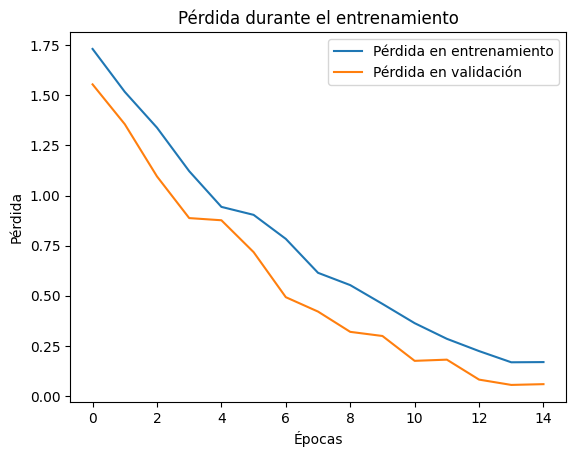

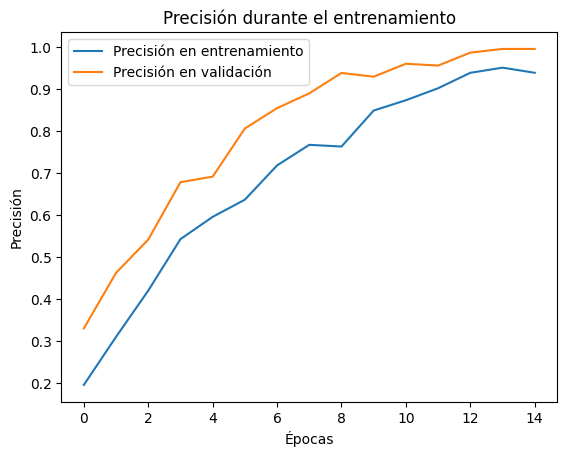

In [14]:
import matplotlib.pyplot as plt

# Graficar la pérdida (loss) durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar la precisión (accuracy) durante el entrenamiento
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()
